# Week 08 Homework
### 8.1

Last week you practiced single band raster calculations using Sentinel-2 satellite remote sensing data. This week you will practice working with the multiple bands associated with Sentinel-2 data in order to create RGB composites and other band manipulations. 

The Sentinel-2 bands are as follows:

![_._](img/sentinel-2-bands.jpg)

You will compare RGB and NDVI images from May 2018 (```data/pre-woolsey-fire/```) and February 2019 (```data/post-woolsey-fire```) over the Santa Monica Mountains which correspond to pre and post-Woolsey fire. The Woolsey fire occured in November 2018. 

1. Create an **automated workflow** which loads, stacks and cleans the bands of a single Sentinel-2 date. 
2. Run this workflow for both dates: pre and post Woolsey fire.
3. Map the RGB composites for both dates.
4. Calculate the NDVI and map both dates.
5. Write a few sentences of what differences you see between the RGB/NDVI maps. 




In [91]:
import os
from glob import glob

import matplotlib.pyplot as plt
import numpy as np
import geopandas as gpd
import xarray as xr
import rioxarray as rxr
import rasterio as rio

In [92]:
import numpy as np
from matplotlib.colors import ListedColormap, BoundaryNorm
import seaborn as sns
from shapely.geometry import mapping
sns.set(font_scale=1.5, style="white")

In [124]:
pre_fire_path = os.path.join("data","pre-woolsey-fire")

# Generate a list of tif files
#glob = tells me what is in a folder on my computer
pre_fire_paths = glob(os.path.join(pre_fire_path,
                                        "*.tiff"))

# Sort the data to ensure bands are in the correct order
pre_fire_paths.sort()
pre_fire_paths

['data/pre-woolsey-fire/2018-05-14-00:00_2018-05-14-23:59_Sentinel-2_L2A_B01_(Raw).tiff',
 'data/pre-woolsey-fire/2018-05-14-00:00_2018-05-14-23:59_Sentinel-2_L2A_B02_(Raw).tiff',
 'data/pre-woolsey-fire/2018-05-14-00:00_2018-05-14-23:59_Sentinel-2_L2A_B03_(Raw).tiff',
 'data/pre-woolsey-fire/2018-05-14-00:00_2018-05-14-23:59_Sentinel-2_L2A_B04_(Raw).tiff',
 'data/pre-woolsey-fire/2018-05-14-00:00_2018-05-14-23:59_Sentinel-2_L2A_B05_(Raw).tiff',
 'data/pre-woolsey-fire/2018-05-14-00:00_2018-05-14-23:59_Sentinel-2_L2A_B06_(Raw).tiff',
 'data/pre-woolsey-fire/2018-05-14-00:00_2018-05-14-23:59_Sentinel-2_L2A_B07_(Raw).tiff',
 'data/pre-woolsey-fire/2018-05-14-00:00_2018-05-14-23:59_Sentinel-2_L2A_B08_(Raw).tiff',
 'data/pre-woolsey-fire/2018-05-14-00:00_2018-05-14-23:59_Sentinel-2_L2A_B09_(Raw).tiff',
 'data/pre-woolsey-fire/2018-05-14-00:00_2018-05-14-23:59_Sentinel-2_L2A_B11_(Raw).tiff',
 'data/pre-woolsey-fire/2018-05-14-00:00_2018-05-14-23:59_Sentinel-2_L2A_B12_(Raw).tiff',
 'data/pre

In [125]:
post_fire_path = os.path.join("data", "post-woolsey-fire")
post_fire_paths = glob(os.path.join(post_fire_path,
                                     "*.tiff"))
post_fire_paths.sort()
post_fire_paths

['data/post-woolsey-fire/2019-02-08-00:00_2019-02-08-23:59_Sentinel-2_L2A_B01_(Raw).tiff',
 'data/post-woolsey-fire/2019-02-08-00:00_2019-02-08-23:59_Sentinel-2_L2A_B02_(Raw).tiff',
 'data/post-woolsey-fire/2019-02-08-00:00_2019-02-08-23:59_Sentinel-2_L2A_B03_(Raw).tiff',
 'data/post-woolsey-fire/2019-02-08-00:00_2019-02-08-23:59_Sentinel-2_L2A_B04_(Raw).tiff',
 'data/post-woolsey-fire/2019-02-08-00:00_2019-02-08-23:59_Sentinel-2_L2A_B05_(Raw).tiff',
 'data/post-woolsey-fire/2019-02-08-00:00_2019-02-08-23:59_Sentinel-2_L2A_B06_(Raw).tiff',
 'data/post-woolsey-fire/2019-02-08-00:00_2019-02-08-23:59_Sentinel-2_L2A_B07_(Raw).tiff',
 'data/post-woolsey-fire/2019-02-08-00:00_2019-02-08-23:59_Sentinel-2_L2A_B08_(Raw).tiff',
 'data/post-woolsey-fire/2019-02-08-00:00_2019-02-08-23:59_Sentinel-2_L2A_B09_(Raw).tiff',
 'data/post-woolsey-fire/2019-02-08-00:00_2019-02-08-23:59_Sentinel-2_L2A_B11_(Raw).tiff',
 'data/post-woolsey-fire/2019-02-08-00:00_2019-02-08-23:59_Sentinel-2_L2A_B12_(Raw).tiff',

In [126]:
sm_boundary_path = os.path.join("data","greater-samo-area.geojson")
samo_boundary = gpd.read_file(sm_boundary_path)
print(samo_boundary.crs)

epsg:4326


In [127]:
pre_crs = rxr.open_rasterio(pre_fire_paths[0], masked=True).squeeze().rio.crs
pre_crs

CRS.from_epsg(4326)

In [128]:
post_crs = rxr.open_rasterio(post_fire_paths[0], masked=True).squeeze().rio.crs
post_crs

CRS.from_epsg(4326)

In [129]:
samo_boundary_use = samo_boundary.to_crs(pre_crs)

In [130]:
def open_clean_band(band_path, clip_extent, valid_range=None):
    """A function that opens a Landsat band as an (rio)xarray object

    Parameters
    ----------
    band_path : list
        A list of paths to the tif files that you wish to combine.

    clip_extent : geopandas geodataframe
        A geodataframe containing the clip extent of interest. NOTE: this will 
        fail if the clip extent is in a different CRS than the raster data.

    valid_range : tuple (optional)
        The min and max valid range for the data. All pixels with values outside
        of this range will be masked.

    Returns
    -------
    An single xarray object with the Landsat band data.

    """

    try:
        clip_bound = clip_extent.geometry
    except Exception as err:
        print("Oops, I need a geodataframe object for this to work.")
        print(err)

    cleaned_band = rxr.open_rasterio(band_path,
                                     masked=True).rio.clip(clip_bound,
                                                           from_disk=True).squeeze()

    # Only mask the data if a valid range tuple is provided
    if valid_range:
        mask = ((landsat_post_xr_clip < valid_range[0]) | (
            landsat_post_xr_clip > valid_range[1]))
        cleaned_band = landsat_post_xr_clip.where(
            ~xr.where(mask, True, False))

    return cleaned_band

In [131]:
pre_all_bands = []
for i, aband in enumerate(pre_fire_paths):
    cleaned = open_clean_band(aband, samo_boundary_use)
    # This line below is only needed if you wish to stack and plot your data
    cleaned["band"] = i+1
    pre_all_bands.append(cleaned)

In [132]:
pre_fire_stack = xr.concat(pre_all_bands, dim="band")
pre_fire_stack

<xarray.DataArray (band: 12, y: 337, x: 625)>
array([[[ 13,  16,  20, ...,  47,  43,  57],
        [ 16,  19,  15, ...,  58,  36,  49],
        [ 20,  19,  13, ...,  54,  30,  37],
        ...,
        [ 12,  12,  12, ...,  23,  24,  27],
        [ 12,  11,  12, ...,  27,  27,  26],
        [ 12,  12,  12, ...,  24,  24,  27]],

       [[ 18,  20,  25, ...,  58,  47,  63],
        [ 21,  24,  17, ...,  76,  40,  53],
        [ 26,  24,  16, ...,  65,  34,  35],
        ...,
        [ 12,  12,  12, ...,  26,  31,  34],
        [ 12,  12,  12, ...,  31,  31,  32],
        [ 13,  12,  12, ...,  29,  26,  32]],

       [[ 27,  29,  31, ...,  61,  50,  66],
        [ 30,  29,  20, ...,  82,  42,  55],
        [ 33,  30,  18, ...,  71,  38,  40],
        ...,
...
        ...,
        [  7,   7,   7, ...,  51,  58,  59],
        [  7,   7,   7, ...,  57,  59,  63],
        [  8,   7,   7, ...,  56,  53,  52]],

       [[ 60,  66,  98, ...,  80,  50,  61],
        [ 71,  93,  55, ...,  74,  47,  51],
        [ 96,  97,  45, ...,  66,  52,  56],
        ...,
        [  7,   7,   7, ...,  44,  50,  47],
        [  7,   6,   7, ...,  51,  52,  56],
        [  7,   7,   6, ...,  48,  45,  44]],

       [[ 95,  89,  59, ...,  63,  63,  84],
        [ 91,  62,  36, ...,  91,  51,  65],
        [ 69,  61,  32, ...,  77,  51,  69],
        ...,
        [  8,   8,   8, ...,  55,  62,  70],
        [  8,   7,   8, ...,  60,  64,  63],
        [  8,   7,   7, ...,  63,  60,  55]]], dtype=uint8)
Coordinates:
  * x            (x) float64 -119.1 -119.1 -119.1 ... -118.5 -118.5 -118.5
  * y            (y) float64 34.27 34.27 34.27 34.27 ... 34.0 34.0 34.0 34.0
  * band         (band) int64 1 2 3 4 5 6 7 8 9 10 11 12
    spatial_ref  int64 0
Attributes:
    AREA_OR_POINT:           Area
    TIFFTAG_RESOLUTIONUNIT:  1 (unitless)
    TIFFTAG_XRESOLUTION:     1
    TIFFTAG_YRESOLUTION:     1
    scale_factor:            1.0
    add_offset:              0.0

In [133]:
post_all_bands = []
for i, aband in enumerate(post_fire_paths):
    cleaned_post = open_clean_band(aband, samo_boundary_use)
    # This line below is only needed if you wish to stack and plot your data
    cleaned_post["band"] = i+1
    post_all_bands.append(cleaned_post)

In [134]:
post_fire_stack = xr.concat(post_all_bands, dim="band")
post_fire_stack

<xarray.DataArray (band: 12, y: 337, x: 625)>
array([[[ 0,  2,  8, ..., 37, 30, 34],
        [ 3,  8,  7, ..., 46, 26, 31],
        [10,  8,  8, ..., 44, 22, 19],
        ...,
        [ 0,  0,  0, ..., 13, 15, 21],
        [ 0,  0,  0, ..., 15, 17, 18],
        [ 0,  0,  0, ..., 16, 15, 17]],

       [[ 4,  6, 15, ..., 43, 37, 41],
        [ 6, 14, 14, ..., 61, 33, 44],
        [18, 14, 13, ..., 54, 28, 26],
        ...,
        [ 1,  1,  1, ..., 18, 20, 31],
        [ 1,  1,  1, ..., 18, 20, 25],
        [ 1,  1,  1, ..., 22, 17, 23]],

       [[10, 12, 23, ..., 46, 41, 46],
        [12, 22, 22, ..., 67, 36, 45],
        [27, 22, 22, ..., 59, 32, 30],
        ...,
...
        ...,
        [ 0,  0,  0, ..., 36, 40, 43],
        [ 0,  0,  0, ..., 37, 40, 47],
        [ 0,  0,  0, ..., 42, 35, 36]],

       [[29, 35, 65, ..., 48, 48, 49],
        [37, 65, 63, ..., 53, 38, 35],
        [73, 64, 62, ..., 51, 44, 44],
        ...,
        [ 0,  0,  0, ..., 30, 34, 33],
        [ 0,  0,  0, ..., 32, 34, 41],
        [ 0,  0,  0, ..., 36, 29, 30]],

       [[69, 68, 61, ..., 47, 46, 53],
        [68, 59, 63, ..., 72, 42, 45],
        [62, 61, 63, ..., 67, 41, 46],
        ...,
        [ 0,  0,  0, ..., 42, 46, 52],
        [ 0,  0,  0, ..., 44, 52, 50],
        [ 0,  0,  0, ..., 48, 44, 41]]], dtype=uint8)
Coordinates:
  * x            (x) float64 -119.1 -119.1 -119.1 ... -118.5 -118.5 -118.5
  * y            (y) float64 34.27 34.27 34.27 34.27 ... 34.0 34.0 34.0 34.0
  * band         (band) int64 1 2 3 4 5 6 7 8 9 10 11 12
    spatial_ref  int64 0
Attributes:
    AREA_OR_POINT:           Area
    TIFFTAG_RESOLUTIONUNIT:  1 (unitless)
    TIFFTAG_XRESOLUTION:     1
    TIFFTAG_YRESOLUTION:     1
    scale_factor:            1.0
    add_offset:              0.0

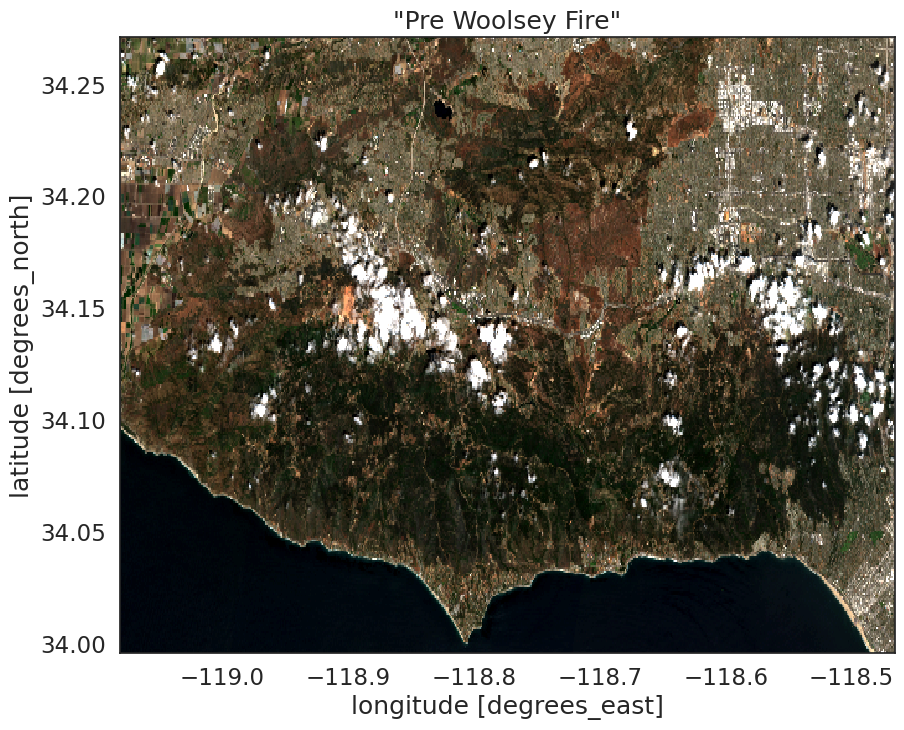

In [135]:
pre_fire_rgb = (pre_fire_stack[[3,2,1],:,:])
pre_fire_rgb.plot.imshow(rgb="band",robust=True, figsize=(10, 8))
plt.title('"Pre Woolsey Fire"')
plt.show()

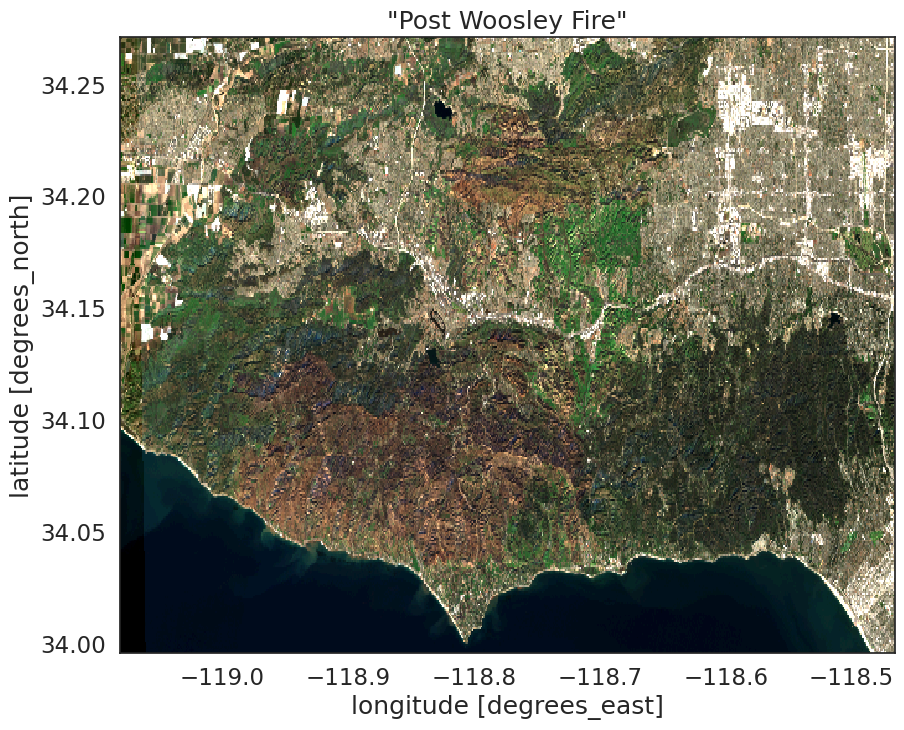

In [136]:
post_fire_rgb = (post_fire_stack[[3,2,1],:,:])
post_fire_rgb.plot.imshow(rgb="band", robust=True, figsize=(10,8))
plt.title('"Post Woosley Fire"')
plt.show()

In [137]:
#Based on the two images there is less green vegetation post fire. 

In [155]:
pre_nir = pre_fire_stack[7]
pre_red = pre_fire_stack[3]
ndvi = (pre_nir.astype(float) - pre_red.astype(float)) / (pre_nir.astype(float)+pre_red.astype(float))

In [156]:
print('\nMax NDVI: {m}'.format(m=ndvi.max()))
print('Mean NDVI: {m}'.format(m=ndvi.mean()))
print('Median NDVI: {m}'.format(m=np.median(ndvi)))
print('Min NDVI: {m}'.format(m=ndvi.min()))


Max NDVI: <xarray.DataArray ()>
array(0.92941176)
Coordinates:
    spatial_ref  int64 0
Mean NDVI: <xarray.DataArray ()>
array(0.32073293)
Coordinates:
    spatial_ref  int64 0
Median NDVI: 0.33858267716535434
Min NDVI: <xarray.DataArray ()>
array(-0.35)
Coordinates:
    spatial_ref  int64 0


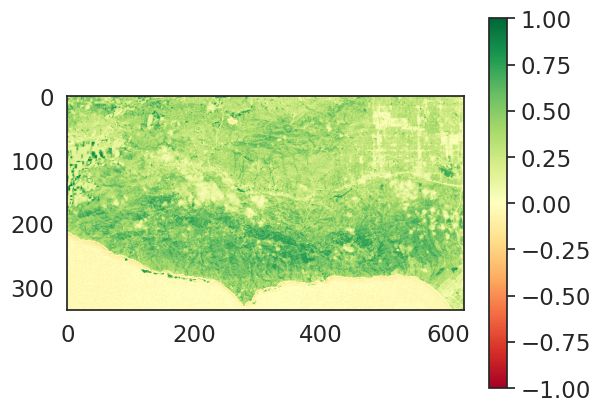

In [161]:
plt.imshow(ndvi, cmap="RdYlGn",
          vmin=-1,vmax=1)
plt.colorbar()
plt.show()

In [158]:
post_nir = post_fire_stack[7]
post_red = post_fire_stack[3]
ndvi2 = (post_nir.astype(float) - post_red.astype(float)) / (post_nir.astype(float)+post_red.astype(float))

In [159]:
print('\nMax NDVI: {m}'.format(m=ndvi2.max()))
print('Mean NDVI: {m}'.format(m=ndvi2.mean()))
print('Median NDVI: {m}'.format(m=np.median(ndvi2)))
print('Min NDVI: {m}'.format(m=ndvi2.min()))


Max NDVI: <xarray.DataArray ()>
array(1.)
Coordinates:
    spatial_ref  int64 0
Mean NDVI: <xarray.DataArray ()>
array(0.36072694)
Coordinates:
    spatial_ref  int64 0
Median NDVI: nan
Min NDVI: <xarray.DataArray ()>
array(-1.)
Coordinates:
    spatial_ref  int64 0


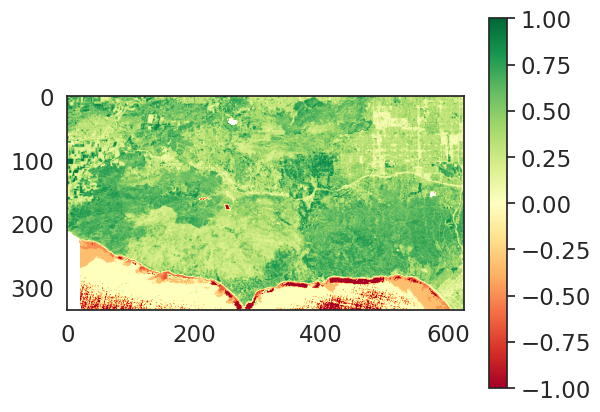

In [160]:
plt.imshow(ndvi2, cmap="RdYlGn")
plt.colorbar()
plt.show()

In [ ]:
#Based on the two maps there is clear indication of where the fire occured bases on the change in color between pre and post fire. 
#The lighter green associated with values between 0.25-0.50 grew between the first and second image indicating less vegetation after the fire. 